## Clone Repo

In [ ]:
# Checks if the directory exists
import os
if os.path.exists("./Pre-trained-Deep-Learning-Models-For-Rapid-Analysis-Of-Piezoelectric-Hysteresis-Loops-SHO-Fitting"):
    pass
else:
    !git clone https://github.com/abekek/Pre-trained-Deep-Learning-Models-For-Rapid-Analysis-Of-Piezoelectric-Hysteresis-Loops-SHO-Fitting.git

In [ ]:
# Checks if the directory exists
import os
if os.path.exists("./Quantized-SHO-Fitting"):
    %cd Quantized-SHO-Fitting
else:
    %mkdir Quantized-SHO-Fitting
    %cd Quantized-SHO-Fitting
    !git clone https://github.com/abekek/Pre-trained-Deep-Learning-Models-For-Rapid-Analysis-Of-Piezoelectric-Hysteresis-Loops-SHO-Fitting.git

In [ ]:
# moves to the right directory
%cd Pre-trained-Deep-Learning-Models-For-Rapid-Analysis-Of-Piezoelectric-Hysteresis-Loops-SHO-Fitting

In [ ]:
# checks if the directory is up to date
!git pull

## Installation & Import

In [ ]:
# Installs all of the requirements
!pip install -r requirements.txt

In [ ]:
# installing PyTorch's Nightly version
!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html -U

!pip install pycroscopy==0.60.7

if os.path.exists("./BGlib"):
    pass
else:
    !git clone https://github.com/pycroscopy/BGlib.git
    %cd BGlib/
    !git tag -l
    !git checkout 0.0.3
    !git branch -D master
    !git checkout -b master
    %cd ..

# downgrading the h5py version
!pip install 'h5py==2.10.0' --force-reinstal

In [ ]:
!pip install hls4ml

In [ ]:
!pip install numba

In [ ]:
!pip install moviepy

In [ ]:
!pip install qkeras

In [ ]:
!pip install hls4ml[profiling]

In [ ]:
import gdown
import multiprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from numba import jit
import random
import time
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import argparse
import seaborn as sns
from scipy.signal import resample
from scipy import fftpack
from scipy import io
from scipy import special
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.layers import (Attention, Dense, Conv1D, Convolution2D, 
                                     GRU, LSTM, Bidirectional, TimeDistributed,
                                     Dropout, Flatten, LayerNormalization, 
                                     RepeatVector, Reshape, MaxPooling1D, 
                                     UpSampling1D, BatchNormalization, Activation)
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, Conv1D, MaxPooling1D
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from multiprocessing import Pool, Process
import multiprocessing as mp
from moviepy.editor import *
import glob
from sklearn.metrics import mean_squared_error
import gc
import sidpy
from BGlib.BGlib import be as belib
 
# set up notebook to show plots within the notebook
%matplotlib inline
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.patches import ConnectionPatch

# Import necessary libraries:
# General utilities:
import sys
import os
import gc

# Computation:
import numpy as np
import h5py
import pandas as pd

# Visualization:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image
from IPython.display import clear_output
from mpl_toolkits.axes_grid1 import ImageGrid

# Finally, pycroscopy itself
sys.path.append('../../../')
import pyUSID as usid
from codes.util.preprocessing_global_standard_scaler import global_standard_scaler
from sidpy.hdf.hdf_utils import write_simple_attrs, get_attr
from pyUSID.io.hdf_utils import create_results_group, write_main_dataset, write_reduced_anc_dsets, create_empty_dataset, reshape_to_n_dims, get_auxiliary_datasets
from pyUSID.io.usi_data import USIDataset
from pyUSID.io import Dimension

from codes.util.file import print_tree
from codes.util.core import SHO_fit_func_torch, loop_fitting_function, loop_fitting_function_tf, computeDotProducts, normOfVar, fit_loop_function, computeTime, conventional_fit_loop_function
from codes.viz.plot import plot_best_worst_SHO, make_movie, plot_best_worst_loops, plot_reconstruction_comparison_SHO, plot_reconstruction_comparison_loops
from codes.util.postprocessing import transform_params, convert_real_imag
from codes.util.preprocessing_global_scaler import global_scaler
from codes.processing.filters import range_filter, clean_interpolate, interpolate_missing_points
from codes.algorithm.TRPCGOptimizerv2 import TRPCGOptimizerv2
from codes.algorithm.AdaHessian import AdaHessian

import numpy.lib.recfunctions as rfn

import hls4ml
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Activation, MaxPool1D, AvgPool1D, Flatten, Dense
from tensorflow.nn import selu
from qkeras import *

## Setting defaults

In [ ]:
# shows the number of CPU cores
multiprocessing.cpu_count()

In [ ]:
# shows the GPU that is available and the resources
!nvidia-smi

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

In [ ]:
# fixes the random seed for reproducible training
torch.set_default_dtype(torch.float32)
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# resetting default seaborn style
sns.reset_orig()

# setting default plotting params
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

## Loading data

In [ ]:
gdown.download('https://drive.google.com/uc?export=download&id=1Q2Qo_1VGlCsVOTjQpZlE5tjoIV1etVe2', 'data_file_copy1.h5', quiet=False)

In [ ]:
# Opens the translated file
h5_f = h5py.File('./data_file_copy1.h5', 'r+')

#Inspects the h5 file
usid.hdf_utils.print_tree(h5_f)

In [ ]:
print('Datasets and datagroups within the file:\n------------------------------------')
print_tree(h5_f.file)
 
print('\nThe main dataset:\n------------------------------------')
print(h5_f)
print('\nThe ancillary datasets:\n------------------------------------')
print(h5_f.file['/Measurement_000/Channel_000/Position_Indices'])
print(h5_f.file['/Measurement_000/Channel_000/Position_Values'])
print(h5_f.file['/Measurement_000/Channel_000/Spectroscopic_Indices'])
print(h5_f.file['/Measurement_000/Channel_000/Spectroscopic_Values'])

print('\nMetadata or attributes in a datagroup\n------------------------------------')
for key in h5_f.file['/Measurement_000'].attrs:
    print('{} : {}'.format(key, h5_f.file['/Measurement_000'].attrs[key]))

In [ ]:
# number of samples per SHO fit
num_bins = h5_f['Measurement_000'].attrs['num_bins'] 

# number of pixels in the image
num_pix = h5_f['Measurement_000'].attrs['num_pix'] 

# number of pixels in x and y dimensions
num_pix_1d = int(np.sqrt(num_pix)) 

# number of DC voltage steps 
voltage_steps = h5_f['Measurement_000'].attrs['num_udvs_steps']

# sampling rate
sampling_rate = h5_f['Measurement_000'].attrs['IO_rate_[Hz]']

# BE bandwidth
be_bandwidth = h5_f['Measurement_000'].attrs['BE_band_width_[Hz]']

# BE center frequency
be_center_frequency = h5_f['Measurement_000'].attrs['BE_center_frequency_[Hz]']

# Frequency Vector in Hz
frequency_bin = h5_f['Measurement_000']['Channel_000']['Bin_Frequencies'][:]

# Resampled frequency vector
wvec_freq = resample(frequency_bin, 80)

In [ ]:
# get raw data (real and imaginary combined)
raw_data = h5_f['Measurement_000']['Channel_000']['Raw_Data']
# resampling it from 165 to 80 frequency steps
raw_data_resampled = resample(np.array(raw_data).reshape(-1 , 165), 80, axis=1)

## Conversion of Real/Imaginary to Magnitude/Phase Representation

In [ ]:
# conversion of raw data (both resampled and full)
magnitude_graph_initial_full, phase_graph_initial_full = convert_real_imag(raw_data)
magnitude_graph_initial, phase_graph_initial = convert_real_imag(raw_data_resampled)

## Resampling the data

In [ ]:
# get real and imaginary components from raw data
real = np.real(h5_f['Measurement_000']['Channel_000']['Raw_Data'])
imag = np.imag(h5_f['Measurement_000']['Channel_000']['Raw_Data'])

# resample both real and imaginary components 
real_resample = resample(real.reshape(num_pix, -1, num_bins), 80, axis=2)
imag_resample = resample(imag.reshape(num_pix, -1, num_bins), 80, axis=2)

In [ ]:
# free up the RAM
del real
del imag
gc.collect();

### Params

In [ ]:
# create a list for parameters
fit_results_list = []
for sublist in np.array(h5_f['Measurement_000']['Channel_000']['Raw_Data-SHO_Fit_000']['Fit']):
    for item in sublist:
        for i in item:
          fit_results_list.append(i)

# flatten parameters list into numpy array
fit_results_list = np.array(fit_results_list).reshape(num_pix,voltage_steps,5)

In [ ]:
# scale the fit results with Standard Scaler
fit_results_scaler = StandardScaler()
scaled_fit_results = fit_results_scaler.fit_transform(fit_results_list.reshape(-1,5))

### Scaler

In [ ]:
# scale the real component of input data
scaler_real = global_standard_scaler()
scaled_data_real = scaler_real.fit_transform(real_resample).reshape(-1, 80)

# scale the imaginary component of input data
scaler_imag = global_standard_scaler()
scaled_data_imag = scaler_imag.fit_transform(imag_resample).reshape(-1, 80)

# stack both components
data_ = np.stack((scaled_data_real, scaled_data_imag),axis=2)

# scale the parameters (now takes only 4 parameters, excluding the R2)
params_scaler = StandardScaler()
scaled_params = params_scaler.fit_transform(fit_results_list.reshape(-1,5)[:,0:4])

# exclude the R2 parameter
params = fit_results_list.reshape(-1,5)[:,0:4]
print(params.shape)

del real_resample
del imag_resample

### Train/Test Split

In [ ]:
data_train, data_test, params_train, params_test = train_test_split(data_, 
                                                                    params, 
                                                                    test_size=0.2,
                                                                    random_state=42)

## Tensorflow/HLS4ML Model

In [ ]:
tf.keras.backend.set_floatx('float32')
# tf.keras.backend.clear_session()
# tf.keras.backend.reset_uids()

### Custom Loss Function

In [ ]:
def SHO_fitting_function(params):
    amp = tf.expand_dims(params[:, 0], 1)
    w_0 = tf.expand_dims(params[:, 1], 1)
    qf  = tf.expand_dims(params[:, 2], 1)
    phi = tf.expand_dims(params[:, 3], 1)
    
    amp = tf.cast(amp, tf.complex128)
    w_0 = tf.cast(w_0, tf.complex128)
    qf = tf.cast(qf, tf.complex128)
    phi = tf.cast(phi, tf.complex128)
    frequency = tf.cast(wvec_freq, tf.complex128)
    
    numer = amp * tf.math.exp((1.j) * phi) * tf.math.square(w_0)
    den_1 = tf.math.square(frequency)
    den_2 = (1.j) * frequency * w_0 / qf
    den_3 = tf.math.square(w_0)
    
    den = den_1 - den_2 - den_3
    func = numer / den
    
    real = tf.math.real(func)
    real_scaled = tf.divide(tf.subtract(tf.cast(real, tf.float32), \
                            tf.convert_to_tensor(scaler_real.mean, dtype=tf.float32)),\
                             tf.convert_to_tensor(scaler_real.std, dtype=tf.float32))
    
    imag = tf.math.imag(func)
    imag_scaled = tf.divide(tf.subtract(tf.cast(imag, tf.complex128), \
                        tf.convert_to_tensor(scaler_imag.mean, dtype=tf.complex128)),\
                          tf.convert_to_tensor(scaler_imag.std, dtype=tf.complex128))
    
    func = tf.stack((real_scaled, tf.cast(imag_scaled, tf.float32)), axis=2)
    return func

In [ ]:
def custom_loss(y_true, y_pred):
    y_true = SHO_fitting_function(y_true)
    unscaled_params = y_pred * tf.convert_to_tensor(np.sqrt(params_scaler.var_[0:4]), dtype=tf.float32) + tf.convert_to_tensor(params_scaler.mean_[0:4], dtype=tf.float32)
    y_pred = SHO_fitting_function(unscaled_params)
    mse = tf.math.square(y_true-y_pred)
    return tf.reduce_mean(mse, axis=-1)

### Original Model

In [186]:
def Conv1D_Block(x, time_step, kernel_size):
    x = Conv1D(time_step, kernel_size, padding='same')(x)
    x = Activation(selu)(x)
    return x

def SHO_Model(n_step=80):
    original_input = tf.keras.Input(shape=(n_step, 2))
    x = Conv1D_Block(original_input, 8, 7)
    x = Conv1D_Block(x, 6, 7)
    x = Conv1D_Block(x, 4, 5)
    
    xfc = Flatten()(x)
    xfc = Dense(20, selu)(xfc)
    xfc = Dense(20, selu)(xfc)
    
    x = MaxPool1D(2, padding='same')(x)
    x = Conv1D_Block(x, 2, 5)
    x = Conv1D_Block(x, 4, 5)
    x = Conv1D_Block(x, 4, 5)
    x = Conv1D_Block(x, 4, 5)
    x = Conv1D_Block(x, 4, 5)
    x = Conv1D_Block(x, 4, 5)
    x = AvgPool1D(2, padding='same')(x)
    x = Conv1D_Block(x, 4, 3)
    x = AvgPool1D(2, padding='same')(x)
    x = Conv1D_Block(x, 4, 3)
    x = AvgPool1D(2, padding='same')(x)
    
    cnn_flat = Flatten()(x)
    encoded = tf.concat([cnn_flat, xfc], 1)
    encoded = tf.keras.layers.concatenate([cnn_flat, xfc], 1)
    embedding = Dense(16, selu)(encoded)
    embedding = Dense(8, selu)(embedding)
    embedding = Dense(4, selu)(embedding)
    
    model = Model(original_input, embedding, name='SHO_Model')
    return model

In [187]:
train_dataset = tf.data.Dataset.from_tensor_slices((data_train, params_train))
test_dataset = tf.data.Dataset.from_tensor_slices((data_test, params_test))
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 512
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [188]:
# lr_values = [0.1, 0.01, 0.001]
# lr_boundaries = [16000, 24000, 32000]
# weight_decay = 0.
# schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=lr_boundaries[:-1], values=lr_values)

model = SHO_Model()
adam = Adam(3e-5)
sgd = SGD()
# adahessian = AdaHessian(schedule, weight_decay=(weight_decay/lr_values[0]))
# adahessian = AdaHessian()
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=sgd, loss=custom_loss)

In [189]:
model.summary()

Model: "SHO_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 80, 2)]      0           []                               
                                                                                                  
 conv1d_209 (Conv1D)            (None, 80, 8)        120         ['input_20[0][0]']               
                                                                                                  
 activation_209 (Activation)    (None, 80, 8)        0           ['conv1d_209[0][0]']             
                                                                                                  
 conv1d_210 (Conv1D)            (None, 80, 6)        342         ['activation_209[0][0]']         
                                                                                          

In [190]:
for layer in model.layers:
    if layer.__class__.__name__ in ['Conv1D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name,layersize)) # 0 = weights, 1 = biases
        if (layersize > 4096): # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name,layersize))

conv1d_209: 112
conv1d_210: 336
conv1d_211: 120
conv1d_212: 40
conv1d_213: 40
conv1d_214: 80
conv1d_215: 80
conv1d_216: 80
conv1d_217: 80
conv1d_218: 48
conv1d_219: 48
dense_95: 6400
Layer dense_95 is too large (6400), are you sure you want to train?
dense_96: 400
dense_97: 640
dense_98: 128
dense_99: 32


In [191]:
model.fit(train_dataset, epochs=40, batch_size=BATCH_SIZE)

Epoch 1/40
4320/4320 [==============================] - 30s 7ms/step - loss: 0.1119
Epoch 2/40
4320/4320 [==============================] - 30s 7ms/step - loss: 0.0256
Epoch 3/40
4320/4320 [==============================] - 30s 7ms/step - loss: 0.0188
Epoch 4/40
4320/4320 [==============================] - 30s 7ms/step - loss: 0.0147
Epoch 5/40
4320/4320 [==============================] - 30s 7ms/step - loss: 0.0142
Epoch 6/40
4320/4320 [==============================] - 30s 7ms/step - loss: 0.0128
Epoch 7/40
2967/4320 [===================>..........] - ETA: 9s - loss: 0.0112

KeyboardInterrupt: 

In [192]:
model.save('saved_models/tf_sho_model_v2')

INFO:tensorflow:Assets written to: saved_models/tf_sho_model_v2/assets


INFO:tensorflow:Assets written to: saved_models/tf_sho_model_v2/assets


### Pruned Model

In [ ]:
# import tensorflow_model_optimization as tfmot
# from tensorflow_model_optimization.sparsity import keras as sparsity
# from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

# NSTEPS = int(data_train.shape[0])  // BATCH_SIZE
# print('Number of training steps per epoch is {}'.format(NSTEPS))

# # Prune all convolutional and dense layers gradually from 0 to 50% sparsity every 2 epochs, 
# # ending by the 10th epoch
# def pruneFunction(layer):
#     pruning_params = {'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity = 0.0,
#                                                                    final_sparsity = 0.50, 
#                                                                    begin_step = NSTEPS*2, 
#                                                                    end_step = NSTEPS*10, 
#                                                                    frequency = NSTEPS)
#                      }
#     if isinstance(layer, tf.keras.layers.Conv1D):
#         return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
#     if isinstance(layer, tf.keras.layers.Dense) and layer.name!='output_dense':
#         return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)  
#     return layer

# model_pruned = tf.keras.models.clone_model(model, clone_function=pruneFunction)

In [ ]:
# model_pruned.summary()

In [ ]:
# train = True # True if you want to retrain, false if you want to load a previsously trained model

# n_epochs = 20

# if train:
#     model_pruned.compile(loss=loss, optimizer=adam)

#     callbacks = [
# #             tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1),
#             tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1),
#             pruning_callbacks.UpdatePruningStep()
#             ] 
    
#     start = time.time()
#     model_pruned.fit(train_dataset, epochs=n_epochs, callbacks=callbacks, batch_size=BATCH_SIZE)   
#     end = time.time()

#     print('It took {} minutes to train Keras model'.format( (end - start)/60.))
    
#     model_pruned.save('pruned_cnn_model.h5')

# else:
#     from qkeras.utils import _add_supported_quantized_objects
#     from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
    
#     co = {}
#     _add_supported_quantized_objects(co)
#     co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
#     model_pruned = tf.keras.models.load_model('pruned_cnn_model.h5', custom_objects=co)

### Pruned and Quantized Model

#### AutoQKeras

In [202]:
from qkeras import print_qstats
# for automatic quantization
import pprint
from qkeras.autoqkeras import *
from qkeras import *
from qkeras.utils import model_quantize

from qkeras.qtools import run_qtools
from qkeras.qtools import settings as qtools_settings
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from qkeras import quantized_bits
from qkeras import QDense, QActivation

q = run_qtools.QTools(model, 
                      process="horowitz", 
                      source_quantizers=[quantized_bits(16, 5, 1)], 
                      is_inference=True, 
                      weights_path=None,
                      keras_quantizer="fp16",
                      keras_accumulator="fp16", 
                      for_reference=False)
q.qtools_stats_print()

energy_dict = q.pe(
    weights_on_memory="fixed",
    activations_on_memory="fixed",
    min_sram_size=8*16*1024*1024,
    rd_wr_on_io=False)

# get stats of energy distribution in each layer
energy_profile = q.extract_energy_profile(
    qtools_settings.cfg.include_energy, energy_dict)
# extract sum of energy of each layer according to the rule specified in
# qtools_settings.cfg.include_energy
total_energy = q.extract_energy_sum(
    qtools_settings.cfg.include_energy, energy_dict)

pprint.pprint(energy_profile)
print()

print("Total energy: {:.6f} uJ".format(total_energy / 1000000.0))

operation count for <keras.layers.pooling.average_pooling1d.AveragePooling1D object at 0x7fd5bc5a99d0> is defaulted to 0
operation count for <keras.layers.pooling.average_pooling1d.AveragePooling1D object at 0x7fd5bc5adbe0> is defaulted to 0
operation count for <keras.layers.pooling.average_pooling1d.AveragePooling1D object at 0x7fd5bc53cc40> is defaulted to 0
{
    "source_quantizers": [
        {
            "quantizer_type": "quantized_bits",
            "bits": 16,
            "int_bits": 6,
            "is_signed": true
        }
    ],
    "conv1d_209": {
        "layer_type": "Conv1D",
        "input_quantizer_list": [
            {
                "quantizer_type": "quantized_bits",
                "bits": 16,
                "int_bits": 6,
                "is_signed": true
            }
        ],
        "weight_quantizer": {
            "quantizer_type": "floating_point",
            "bits": 16,
            "shape": [
                7,
                2,
                8
 

In [203]:
# These are the quantizers we'll test in the bayesian optimization
quantization_config = {
        "kernel": {
                "quantized_bits(2,0,1,alpha=1.0)": 2,
                "quantized_bits(4,0,1,alpha=1.0)": 4,
                "quantized_bits(6,0,1,alpha=1.0)": 6,
                "quantized_bits(8,0,1,alpha=1.0)": 8,
        },
        "bias": {
                "quantized_bits(2,0,1,alpha=1.0)": 2,
                "quantized_bits(4,0,1,alpha=1.0)": 4,
                "quantized_bits(6,0,1,alpha=1.0)": 6,
                "quantized_bits(8,0,1,alpha=1.0)": 8,
        },
        "activation": {
                "quantized_relu(3,1)": 3,
                "quantized_relu(4,2)": 4,
                "quantized_relu(8,2)": 8,
                "quantized_relu(8,4)": 8,
                "quantized_relu(16,6)": 16
        },
        "linear": {
                "quantized_bits(2,0,1,alpha=1.0)": 2,
                "quantized_bits(4,0,1,alpha=1.0)": 4,
                "quantized_bits(6,0,1,alpha=1.0)": 6,
                "quantized_bits(8,0,1,alpha=1.0)": 8,
        }
}

# These are the layer types we will quantize
limit = {
    "Dense": [8, 8, 16],
    "Conv1D": [8, 8, 16],
    "Activation": [16],
}

# Use this if you want to minimize the model bit size
goal_bits = {
    "type": "bits",
          "params": {
              "delta_p": 2.0, # We tolerate up to a +8% accuracy change
              "delta_n": 2.0, # We tolerate down to a -8% accuracy change
              "rate": 2.0,    # We want a x2 times smaller model
              "stress": 1.0,  # Force the reference model size to be smaller by setting stress<1
              "input_bits": 8,
              "output_bits": 8,
              "ref_bits": 8,
              "config": {
                  "default": ["parameters", "activations"]
              }
          }
}

# Use this if you want to minimize the model energy consumption
goal_energy = {
    "type": "energy",
    "params": {
        "delta_p": 2.0,
        "delta_n": 2.0,
        "rate": 2.0,
        "stress": 1.0,
        "process": "horowitz",
        "parameters_on_memory": ["sram", "sram"],
        "activations_on_memory": ["sram", "sram"],
        "rd_wr_on_io": [False, False],
        "min_sram_size": [0, 0],
        "source_quantizers": ["fp32"],
        "reference_internal": "int8",
        "reference_accumulator": "int32"
        }
}

run_config = {
        "goal": goal_bits,
        "quantization_config": quantization_config,
        "learning_rate_optimizer": False,
        "transfer_weights": False, # Randomely initialize weights
        "mode": "bayesian", # This can be bayesian,random,hyperband
        "seed": 42,
        "limit": limit,
        "tune_filters": "layer",
        "tune_filters_exceptions": "^output",
        "distribution_strategy": None,
        "layer_indexes": range(1, len(model.layers)-1),
        "max_trials": 5 # Let's just do 5 trials for this demonstrator, ideally you should do as many as possible
}

In [204]:
from qkeras.autoqkeras import AutoQKeras

autoqk = AutoQKeras(model, metrics=[custom_loss], output_dir="autoq_cnn", **run_config)
autoqk.fit(train_dataset, validation_data=test_dataset, epochs=10)

aqmodel = autoqk.get_best_model()
print_qmodel_summary(aqmodel)   

# Train for the full epochs
callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
            ]  

start = time.time()
history = aqmodel.fit(train_dataset,
                      validation_data=test_dataset,
                      epochs = 15,
                      callbacks = callbacks, 
                      verbose=1)     
end = time.time()
print('\n It took {} minutes to train!\n'.format( (end - start)/60.))

Limit configuration:{"Dense": [8, 8, 16], "Conv1D": [8, 8, 16], "Activation": [16]}
learning_rate: 0.009999999776482582
Model: "SHO_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 80, 2)]      0           []                               
                                                                                                  
 conv1d_209 (QConv1D)           (None, 80, 8)        120         ['input_20[0][0]']               
                                                                                                  
 activation_209 (QActivation)   (None, 80, 8)        0           ['conv1d_209[0][0]']             
                                                                                                  
 conv1d_210 (QConv1D)           (None, 80, 6)        342         ['ac

learning_rate: 0.009999999776482582
Model: "SHO_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 80, 2)]      0           []                               
                                                                                                  
 conv1d_209 (QConv1D)           (None, 80, 16)       240         ['input_20[0][0]']               
                                                                                                  
 activation_209 (QActivation)   (None, 80, 16)       0           ['conv1d_209[0][0]']             
                                                                                                  
 conv1d_210 (QConv1D)           (None, 80, 9)        1017        ['activation_209[0][0]']         
                                                      

4320/4320 [==============================] - 54s 12ms/step - loss: 0.1287 - custom_loss: 0.1287 - trial: 54833.1328 - score: 0.1306 - val_loss: 0.1099 - val_custom_loss: 0.1099 - val_trial: 54836.0000 - val_score: 0.1116
Epoch 2/10
4320/4320 [==============================] - 51s 12ms/step - loss: 0.0652 - custom_loss: 0.0652 - trial: 54833.1328 - score: 0.0662 - val_loss: 0.0400 - val_custom_loss: 0.0400 - val_trial: 54836.0000 - val_score: 0.0406
Epoch 3/10
4320/4320 [==============================] - 51s 12ms/step - loss: 0.0499 - custom_loss: 0.0499 - trial: 54833.1328 - score: 0.0506 - val_loss: 0.0290 - val_custom_loss: 0.0290 - val_trial: 54836.0000 - val_score: 0.0295
Epoch 4/10
4320/4320 [==============================] - 50s 12ms/step - loss: 0.0426 - custom_loss: 0.0426 - trial: 54833.1328 - score: 0.0432 - val_loss: 0.0365 - val_custom_loss: 0.0365 - val_trial: 54836.0000 - val_score: 0.0370
Epoch 5/10
4320/4320 [==============================] - 51s 12ms/step - loss: 0.049

                                                                                                  
 conv1d_213 (QConv1D)           (None, 40, 4)        24          ['activation_212[0][0]']         
                                                                                                  
 activation_213 (QActivation)   (None, 40, 4)        0           ['conv1d_213[0][0]']             
                                                                                                  
 conv1d_214 (QConv1D)           (None, 40, 6)        126         ['activation_213[0][0]']         
                                                                                                  
 activation_214 (QActivation)   (None, 40, 6)        0           ['conv1d_214[0][0]']             
                                                                                                  
 conv1d_215 (QConv1D)           (None, 40, 2)        62          ['activation_214[0][0]']         
          

4320/4320 [==============================] - 50s 12ms/step - loss: 0.0399 - custom_loss: 0.0399 - trial: 67982.6250 - score: 0.0403 - val_loss: 0.0349 - val_custom_loss: 0.0349 - val_trial: 67984.0000 - val_score: 0.0352
Epoch 3/10
4320/4320 [==============================] - 50s 12ms/step - loss: 0.0302 - custom_loss: 0.0302 - trial: 67982.6250 - score: 0.0305 - val_loss: 0.0284 - val_custom_loss: 0.0284 - val_trial: 67984.0000 - val_score: 0.0286

Trial 2 Complete [00h 02m 34s]
val_score: 0.035178784281015396

Best val_score So Far: 0.11156419664621353
Total elapsed time: 00h 08m 33s


2022-06-22 15:05:07.466493: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x562a2a585630



Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
quantized_bits(...|quantized_bits(...|conv1d_209_kernel_quantizer
quantized_bits(...|quantized_bits(...|conv1d_210_kernel_quantizer
quantized_bits(...|quantized_bits(...|conv1d_211_kernel_quantizer
quantized_bits(...|quantized_bits(...|conv1d_212_kernel_quantizer
quantized_bits(...|quantized_bits(...|conv1d_213_kernel_quantizer
quantized_bits(...|quantized_bits(...|conv1d_214_kernel_quantizer
quantized_bits(...|quantized_bits(...|conv1d_215_kernel_quantizer
quantized_bits(...|quantized_bits(...|conv1d_216_kernel_quantizer
quantized_bits(...|quantized_bits(...|conv1d_217_kernel_quantizer
quantized_bits(...|quantized_bits(...|conv1d_218_kernel_quantizer
quantized_bits(...|quantized_bits(...|conv1d_219_kernel_quantizer
quantized_bits(...|quantized_bits(...|dense_95_kernel_quantizer
quantized_bits(...|quantized_bits(...|dense_96_kernel_quantizer
quantized_bits(...|quantized_bits(...|dense_97_kernel_quantizer
qu

                                                                                                  
 activation_217 (QActivation)   (None, 40, 3)        0           ['conv1d_217[0][0]']             
                                                                                                  
 average_pooling1d_57 (AverageP  (None, 20, 3)       0           ['activation_217[0][0]']         
 ooling1D)                                                                                        
                                                                                                  
 conv1d_218 (QConv1D)           (None, 20, 3)        30          ['average_pooling1d_57[0][0]']   
                                                                                                  
 activation_218 (QActivation)   (None, 20, 3)        0           ['conv1d_218[0][0]']             
                                                                                                  
 average_p

learning_rate: 0.009999999776482582
Model: "SHO_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 80, 2)]      0           []                               
                                                                                                  
 conv1d_209 (QConv1D)           (None, 80, 16)       240         ['input_20[0][0]']               
                                                                                                  
 activation_209 (QActivation)   (None, 80, 16)       0           ['conv1d_209[0][0]']             
                                                                                                  
 conv1d_210 (QConv1D)           (None, 80, 4)        452         ['activation_209[0][0]']         
                                                      

4320/4320 [==============================] - 54s 12ms/step - loss: 0.4358 - custom_loss: 0.4358 - trial: 71538.9688 - score: 0.4389 - val_loss: 0.4080 - val_custom_loss: 0.4080 - val_trial: 71539.4844 - val_score: 0.4109
Epoch 2/10
4320/4320 [==============================] - 51s 12ms/step - loss: 0.3971 - custom_loss: 0.3971 - trial: 71538.9688 - score: 0.3999 - val_loss: 0.3956 - val_custom_loss: 0.3956 - val_trial: 71539.4844 - val_score: 0.3985
Epoch 3/10
4320/4320 [==============================] - 51s 12ms/step - loss: 0.3970 - custom_loss: 0.3970 - trial: 71538.9688 - score: 0.3998 - val_loss: 0.3843 - val_custom_loss: 0.3843 - val_trial: 71539.4844 - val_score: 0.3871
Epoch 4/10
4320/4320 [==============================] - 51s 12ms/step - loss: 0.3962 - custom_loss: 0.3962 - trial: 71538.9688 - score: 0.3991 - val_loss: 0.3847 - val_custom_loss: 0.3847 - val_trial: 71539.4844 - val_score: 0.3875
Epoch 5/10
4320/4320 [==============================] - 51s 12ms/step - loss: 0.393

                                                                                                  
 conv1d_213 (QConv1D)           (None, 40, 2)        12          ['activation_212[0][0]']         
                                                                                                  
 activation_213 (QActivation)   (None, 40, 2)        0           ['conv1d_213[0][0]']             
                                                                                                  
 conv1d_214 (QConv1D)           (None, 40, 3)        33          ['activation_213[0][0]']         
                                                                                                  
 activation_214 (QActivation)   (None, 40, 3)        0           ['conv1d_214[0][0]']             
                                                                                                  
 conv1d_215 (QConv1D)           (None, 40, 8)        128         ['activation_214[0][0]']         
          

4320/4320 [==============================] - 51s 12ms/step - loss: 0.4001 - custom_loss: 0.4001 - trial: 90197.1484 - score: 0.4003 - val_loss: 0.3949 - val_custom_loss: 0.3949 - val_trial: 90192.6875 - val_score: 0.3951
Epoch 3/10
4320/4320 [==============================] - 51s 12ms/step - loss: 0.3931 - custom_loss: 0.3931 - trial: 90197.1484 - score: 0.3933 - val_loss: 0.3878 - val_custom_loss: 0.3878 - val_trial: 90192.6875 - val_score: 0.3879
Epoch 4/10
4320/4320 [==============================] - 51s 12ms/step - loss: 0.3893 - custom_loss: 0.3893 - trial: 90197.1484 - score: 0.3894 - val_loss: 0.4069 - val_custom_loss: 0.4069 - val_trial: 90192.6875 - val_score: 0.4071
Epoch 5/10
4320/4320 [==============================] - 51s 12ms/step - loss: 0.3924 - custom_loss: 0.3924 - trial: 90197.1484 - score: 0.3926 - val_loss: 0.3956 - val_custom_loss: 0.3956 - val_trial: 90192.6875 - val_score: 0.3958

Trial 5 Complete [00h 04m 19s]
val_score: 0.4071003794670105

Best val_score So Fa

INFO:tensorflow:Oracle triggered exit


learning_rate: 0.009999999776482582
Model: "SHO_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 80, 2)]      0           []                               
                                                                                                  
 conv1d_209 (QConv1D)           (None, 80, 16)       240         ['input_20[0][0]']               
                                                                                                  
 activation_209 (QActivation)   (None, 80, 16)       0           ['conv1d_209[0][0]']             
                                                                                                  
 conv1d_210 (QConv1D)           (None, 80, 4)        452         ['activation_209[0][0]']         
                                                      

4320/4320 [==============================] - 54s 12ms/step - loss: 0.2370 - custom_loss: 0.2370 - trial: 71538.9688 - score: 0.2386 - val_loss: 0.0726 - val_custom_loss: 0.0726 - val_trial: 71539.4844 - val_score: 0.0731 - lr: 0.0100
Epoch 2/15
4320/4320 [==============================] - 51s 12ms/step - loss: 0.0881 - custom_loss: 0.0881 - trial: 71538.9688 - score: 0.0887 - val_loss: 0.1424 - val_custom_loss: 0.1424 - val_trial: 71539.4844 - val_score: 0.1434 - lr: 0.0100
Epoch 3/15
4320/4320 [==============================] - 50s 12ms/step - loss: 0.0660 - custom_loss: 0.0660 - trial: 71538.9688 - score: 0.0665 - val_loss: 0.0519 - val_custom_loss: 0.0519 - val_trial: 71539.4844 - val_score: 0.0523 - lr: 0.0100
Epoch 4/15
4320/4320 [==============================] - 50s 12ms/step - loss: 0.0496 - custom_loss: 0.0496 - trial: 71538.9688 - score: 0.0500 - val_loss: 0.0452 - val_custom_loss: 0.0452 - val_trial: 71539.4844 - val_score: 0.0456 - lr: 0.0100
Epoch 5/15
4320/4320 [=========

stats: delta_p=0.02 delta_n=0.02 rate=2.0 trial_size=60396 reference_size=91584
       delta=1.20%
       a_bits=20816/21344 (-2.47%) p_bits=39580/70240 (-43.65%)
       total=60396/91584 (-34.05%)

In [205]:
# This model has some remnants from the optimization procedure attached to it, so let's define a new one
aqmodel.save("saved_models/autoqkeras_cnn_v1")

INFO:tensorflow:Assets written to: saved_models/autoqkeras_cnn_v1/assets


INFO:tensorflow:Assets written to: saved_models/autoqkeras_cnn_v1/assets


In [ ]:
new_model = tf.keras.models.load_model('saved_models/autoqkeras_cnn_v1', compile=False)  

new_model.compile(loss=custom_loss, optimizer=sgd)
new_model.summary()
# print_qmodel_summary(new_model)  

### Converting to HLS Model

In [207]:
config = hls4ml.utils.config_from_keras_model(new_model, granularity='name')

Interpreting Model
Topology:
Layer name: input_20, layer type: Input
Layer name: conv1d_209, layer type: QConv1D
  -> Activation (linear), layer name: conv1d_209
Layer name: activation_209, layer type: QActivation
  -> Activation (quantized_relu(16,6)), layer name: activation_209
Layer name: conv1d_210, layer type: QConv1D
  -> Activation (linear), layer name: conv1d_210
Layer name: activation_210, layer type: QActivation
  -> Activation (quantized_relu(16,6)), layer name: activation_210
Layer name: conv1d_211, layer type: QConv1D
  -> Activation (linear), layer name: conv1d_211
Layer name: activation_211, layer type: QActivation
  -> Activation (quantized_relu(3,1)), layer name: activation_211
Layer name: max_pooling1d_19, layer type: MaxPooling1D
Layer name: conv1d_212, layer type: QConv1D
  -> Activation (linear), layer name: conv1d_212
Layer name: activation_212, layer type: QActivation
  -> Activation (quantized_relu(3,1)), layer name: activation_212
Layer name: conv1d_213, layer 

In [216]:
config['Model']['ReuseFactor'] = 12
config['Model']['Strategy'] = 'Resource'

i = 0
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['ReuseFactor'] = 12
    config['LayerName'][layer]['Strategy'] = 'Resource'

In [217]:
config

{'Model': {'Precision': 'ap_fixed<16,6>',
  'ReuseFactor': 12,
  'Strategy': 'Resource'},
 'LayerName': {'input_20': {'Precision': {'result': 'ap_fixed<16,6>'},
   'Strategy': 'Resource',
   'ReuseFactor': 12},
  'conv1d_209': {'Precision': {'weight': 'ap_fixed<2,1>',
    'bias': 'ap_fixed<4,1>'},
   'ReuseFactor': 12,
   'Strategy': 'Resource'},
  'conv1d_209_linear': {'Precision': 'ap_fixed<16,6>',
   'ReuseFactor': 12,
   'table_size': 1024,
   'table_t': 'ap_fixed<18,8>',
   'Strategy': 'Resource'},
  'activation_209': {'Precision': {'result': 'ap_ufixed<16,6>'},
   'ReuseFactor': 12,
   'Strategy': 'Resource'},
  'activation_209_quantized_relu(16,6)': {'Precision': 'ap_fixed<16,6>',
   'ReuseFactor': 12,
   'table_size': 1024,
   'table_t': 'ap_fixed<18,8>',
   'Strategy': 'Resource'},
  'conv1d_210': {'Precision': {'weight': 'ap_fixed<2,1>',
    'bias': 'ap_fixed<8,1>'},
   'ReuseFactor': 12,
   'Strategy': 'Resource'},
  'conv1d_210_linear': {'Precision': 'ap_fixed<16,6>',
   'R

In [218]:
# Convert to an hls model
hls_model = hls4ml.converters.convert_from_keras_model(new_model, hls_config=config, output_dir='autoqkerascnn_v1')

Interpreting Model
Topology:
Layer name: input_20, layer type: InputLayer, input shapes: [[None, 80, 2]], output shape: [None, 80, 2]
Layer name: conv1d_209, layer type: QConv1D, input shapes: [[None, 80, 2]], output shape: [None, 80, 16]
Layer name: activation_209, layer type: Activation, input shapes: [[None, 80, 16]], output shape: [None, 80, 16]
Layer name: conv1d_210, layer type: QConv1D, input shapes: [[None, 80, 16]], output shape: [None, 80, 4]
Layer name: activation_210, layer type: Activation, input shapes: [[None, 80, 4]], output shape: [None, 80, 4]
Layer name: conv1d_211, layer type: QConv1D, input shapes: [[None, 80, 4]], output shape: [None, 80, 8]
Layer name: activation_211, layer type: Activation, input shapes: [[None, 80, 8]], output shape: [None, 80, 8]
Layer name: max_pooling1d_19, layer type: MaxPooling1D, input shapes: [[None, 80, 8]], output shape: [None, 40, 8]
Layer name: conv1d_212, layer type: QConv1D, input shapes: [[None, 40, 8]], output shape: [None, 40, 1

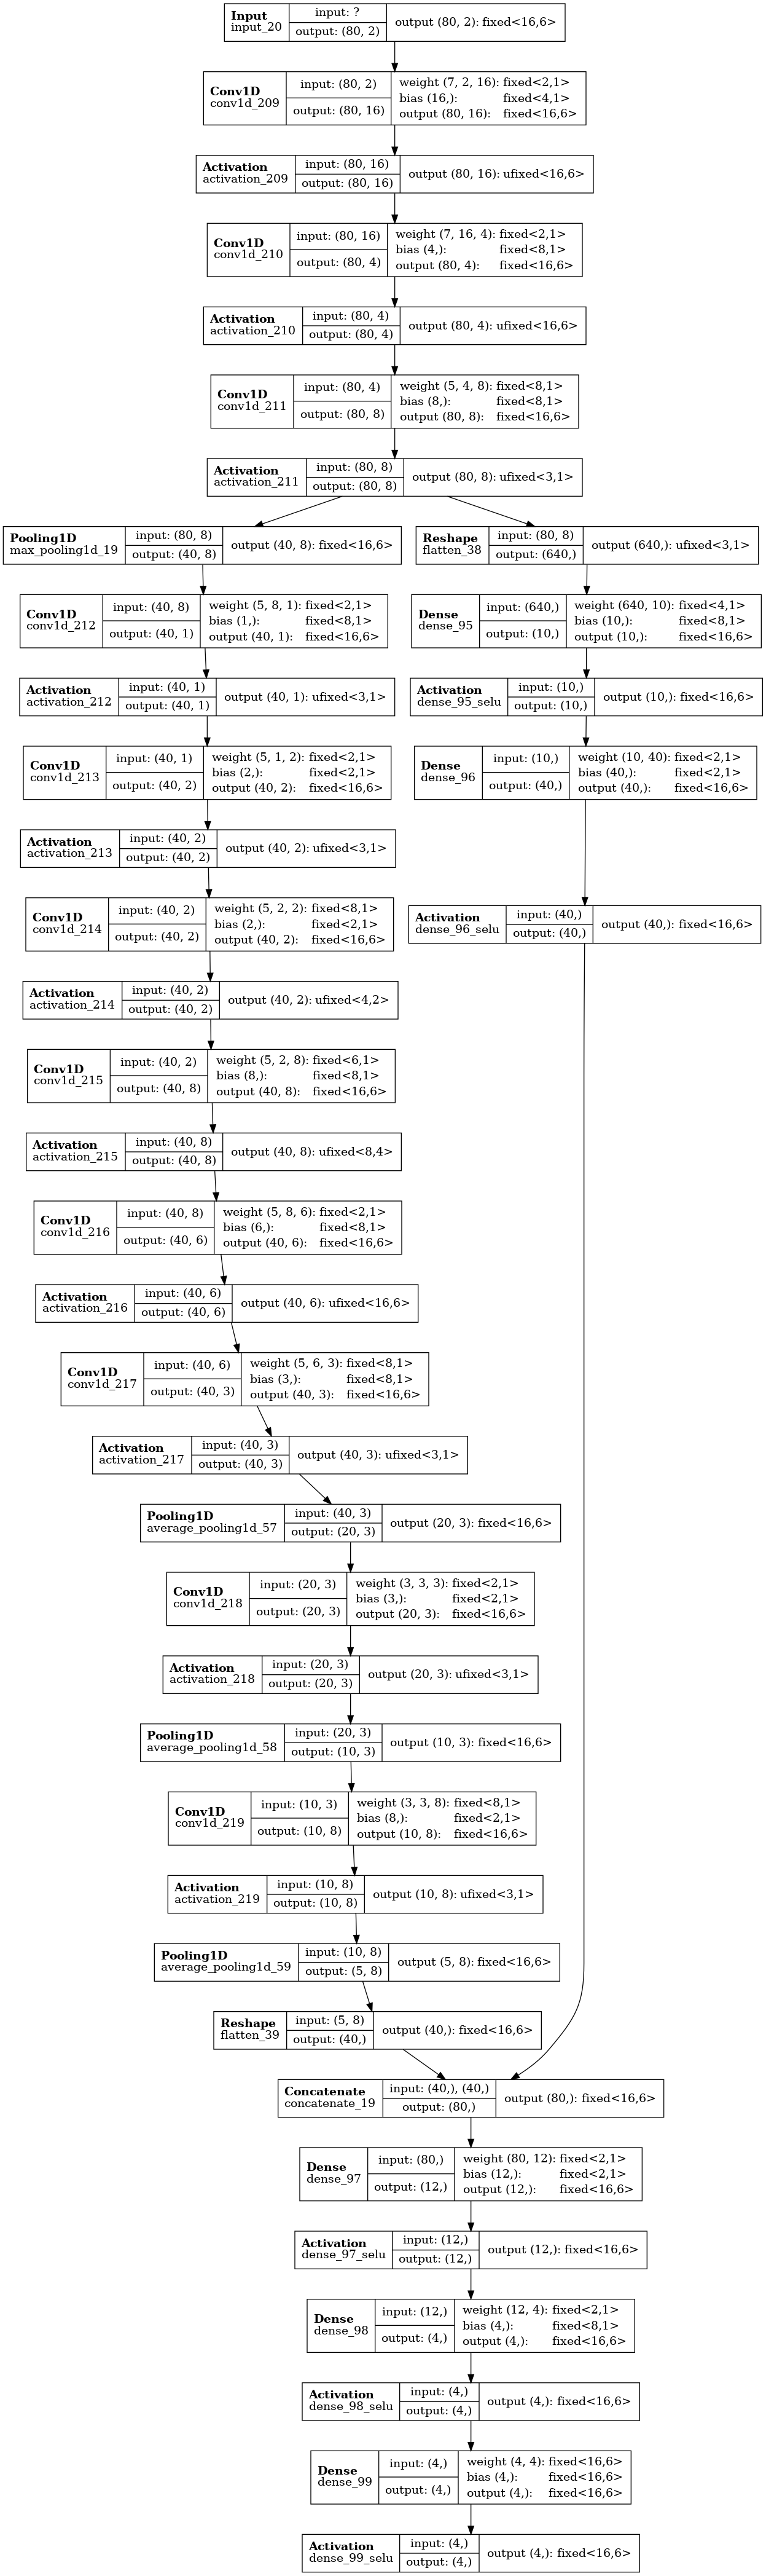

In [219]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [220]:
# hls_model.write()

In [221]:
hls_model.compile()

Writing HLS project
Done


In [ ]:
hls_model.build(csim=False, synth=True, vsynth=True, export=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'ferroelectric' on host 'ferroelectric' (Linux_x86_64 version 5.13.0-41-generic) on Wed Jun 22 16:06:06 EDT 2022
INFO: [HLS 200-10] On os Ubuntu 20.04.3 LTS
INFO: [HLS 200-10] In directory '/home/ferroelectric/Desktop/Alibek/Quantized-SHO-Fitting/Pre-trained-Deep-Learning-Models-For-Rapid-Analysis-Of-Piezoelectric-Hysteresis-Loops-SHO-Fitting/autoqkerascnn_v1'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/ferroelectric/Desktop/Alibek/Quantized-SHO-Fitting/Pre-trained-Deep-Learning-Models-For-Rapid-Analysis-Of-Pie

INFO: [XFORM 203-603] Inlining function 'nnet::product::mult<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<2, 1, (ap_q_mode)5, (ap_o_mode)3, 0> >::product' into 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' (firmware/nnet_utils/nnet_dense_resource.h:77).
INFO: [XFORM 203-603] Inlining function 'nnet::product::mult<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<2, 1, (ap_q_mode)5, (ap_o_mode)3, 0> >::product' into 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12_mult>' (firmware/nnet_utils/nnet_dense_resource.h:77).
INFO: [XFORM 203-603] Inlining function 'nnet::product::mult<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<2, 1, (ap_q_mode)5, (ap_o_mode)3, 0> >::product' into 'nnet::dense_resource_rf_leq_nin<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (a

INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' into 'nnet::dense_resource<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2_mult>' (firmware/nnet_utils/nnet_dense_resource.h:100->firmware/nnet_utils/nnet_dense_resource.h:276) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::conv_1d_resource_cl<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' into 'nnet::conv_1d_cl<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' (firmware/nnet_utils/nnet_conv1d.h:64) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_ufixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5_mult>' into 'nnet::dense_resource<ap_ufixed<16, 6, (ap_q_mode)5, (ap_o_mode)

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:35 ; elapsed = 00:00:36 . Memory (MB): peak = 932.414 ; gain = 528.328 ; free physical = 40919 ; free virtual = 95731
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::selu<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, selu_config51>' (firmware/nnet_utils/nnet_activation.h:765:13).
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:152) in function 'nnet::dense_resource<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config50>' for pipelining.
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::selu<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, selu_config49>' (firmware/nnet_utils/nnet_activation.h:765:13).
INFO: [XFORM 203-502] Unrolling all sub-loops in

INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_resource.h:98) in function 'nnet::dense_resource<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config48>' completely with a factor of 4.
INFO: [HLS 200-489] Unrolling loop 'Loop-1' (firmware/nnet_utils/nnet_activation.h:772) in function 'nnet::selu<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, selu_config47>' completely with a factor of 12.
INFO: [HLS 200-489] Unrolling loop 'InitAccum' (firmware/nnet_utils/nnet_dense_resource.h:58) in function 'nnet::dense_resource<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config46>' completely with a factor of 12.
INFO: [HLS 200-489] Unrolling loop 'MultLoop' (firmware/nnet_utils/nnet_dense_resource.h:73) in function 'nnet::dense_resource<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mod

INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_resource.h:98) in function 'nnet::dense_resource<ap_ufixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config27_mult>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling loop 'KernelLoop' (firmware/nnet_utils/nnet_conv1d_resource.h:146) in function 'nnet::im2col_1d_cl<ap_ufixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config27>' completely with a factor of 5.
INFO: [HLS 200-489] Unrolling loop 'ChannelLoop' (firmware/nnet_utils/nnet_conv1d_resource.h:150) in function 'nnet::im2col_1d_cl<ap_ufixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config27>' completely with a factor of 6.
INFO: [HLS 200-489] Unrolling loop 'Loop-1' (firmware/nnet_utils/nnet_activation.h:76) in function 'nnet::relu<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_ufixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, relu_config26>' completely with a factor of 240.
INFO: [HLS 200-489] Unrolling loo

INFO: [HLS 200-489] Unrolling loop 'Loop-1.1' (firmware/nnet_utils/nnet_conv1d_resource.h:210) in function 'nnet::conv_1d_resource_cl<ap_ufixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>' completely with a factor of 8.
INFO: [HLS 200-489] Unrolling loop 'InitAccum' (firmware/nnet_utils/nnet_dense_resource.h:58) in function 'nnet::dense_resource<ap_ufixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8_mult>' completely with a factor of 8.
INFO: [HLS 200-489] Unrolling loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:64) in function 'nnet::dense_resource<ap_ufixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8_mult>' completely with a factor of 10.
INFO: [HLS 200-489] Unrolling loop 'MultLoop' (firmware/nnet_utils/nnet_dense_resource.h:73) in function 'nnet::dense_resource<ap_ufixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<

INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_resource.h:54) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b40.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_resource.h:54) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'data_col.V' (firmware/nnet_utils/nnet_conv1d_resource.h:199) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'res_col'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b35.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_dense_resource.h:54) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'data_col.V' (firmware/nnet_utils/nnet_conv1d_resource.h:199) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'res_col.V' (firmware/nnet_utils/nnet_conv1d_resource.h:200) in dimension 1 completely.
INFO: [XF

In [ ]:
hls4ml.report.read_vivado_report('autoqkerascnn')

In [ ]:
def Conv1D_Block(x, time_step, kernel_size):
    x = QConv1D(time_step, kernel_size, padding='same', 
                kernel_quantizer="stochastic_ternary", bias_quantizer="ternary")(x)
    x = QActivation('quantized_relu(6)')(x)
    return x

def QSHO_Model(n_step=80):
    original_input = tf.keras.Input(shape=(n_step, 2))
    x = Conv1D_Block(original_input, 8, 7)
    x = Conv1D_Block(x, 6, 7)
    x = Conv1D_Block(x, 4, 5)
    
    xfc = Flatten()(x)
    xfc = QDense(20, kernel_quantizer='quantized_bits(6, 0)',
                    kernel_initializer='lecun_uniform', use_bias=False)(xfc)
    xfc = QDense(20, kernel_quantizer='quantized_bits(6, 0)',
                    kernel_initializer='lecun_uniform', use_bias=False)(xfc)
    
    x = MaxPool1D(2, padding='same')(x)
    x = Conv1D_Block(x, 2, 5)
    x = Conv1D_Block(x, 4, 5)
    x = Conv1D_Block(x, 4, 5)
    x = Conv1D_Block(x, 4, 5)
    x = Conv1D_Block(x, 4, 5)
    x = Conv1D_Block(x, 4, 5)
    x = AvgPool1D(2, padding='same')(x)
    x = Conv1D_Block(x, 4, 3)
    x = AvgPool1D(2, padding='same')(x)
    x = Conv1D_Block(x, 4, 3)
    x = AvgPool1D(2, padding='same')(x)
    
    cnn_flat = Flatten()(x)
    encoded = tf.concat([cnn_flat, xfc], 1)
    encoded = tf.keras.layers.concatenate([cnn_flat, xfc], 1)
    embedding = QDense(16, kernel_quantizer='quantized_bits(6, 0)',
                    kernel_initializer='lecun_uniform', use_bias=False)(encoded)
    embedding = QDense(8, kernel_quantizer='quantized_bits(6, 0)',
                    kernel_initializer='lecun_uniform', use_bias=False)(embedding)
    embedding = Dense(4, selu)(embedding)
    
    qmodel = Model(original_input, embedding, name='QSHO_Model')
    return qmodel

In [ ]:
qmodel = QSHO_Model()
qmodel.summary()

In [ ]:
# Print the quantized layers
from qkeras.autoqkeras.utils import print_qmodel_summary
print_qmodel_summary(qmodel)  

In [ ]:
qmodel.compile(optimizer=sgd, loss=loss)

In [ ]:
qmodel.fit(train_dataset, batch_size=BATCH_SIZE, epochs=n_epochs*2)

In [ ]:
hls_model.predict(data_train[:500]).shape

In [ ]:
!tar -zxvf test_prj.tar.gz

## Profiling

In [ ]:
# keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, data_test)

In [ ]:
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True

In [ ]:
from hls4ml.model.profiling import numerical
from hls4ml.converters import keras_to_hls
import matplotlib.pyplot as plt
import yaml
from yaml import FullLoader

# pseudo code:
model = tf.keras.models.load_model('saved_models/tf_sho_model')
X = data_test.copy()

# produce an activation profile (ap)
# and weights profile (wp)
ap, wp = numerical(model=model, hls_model=hls_model, X=X)
plt.show()

In [ ]:
gc.collect()

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.eager import def_function
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend_config
# from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.keras import optimizers
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.training import training_ops
from tensorflow.python.util.tf_export import keras_export


import abc
import contextlib
import functools

import six
import tensorflow as tf
import numpy as np
from tensorflow.python.distribute import distribution_strategy_context as distribute_ctx
from tensorflow.python.distribute import parameter_server_strategy
from tensorflow.python.distribute import reduce_util as ds_reduce_util
from tensorflow.python.distribute import values as ds_values
from tensorflow.python.eager import backprop
from tensorflow.python.eager import context
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_util
from tensorflow.python.keras import backend
from tensorflow.python.keras import initializers
from tensorflow.python.keras.engine import base_layer_utils
from tensorflow.python.keras.optimizer_v2 import learning_rate_schedule
from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import gradients
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import resource_variable_ops
from tensorflow.python.ops import variables as tf_variables
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.saved_model import revived_types
from tensorflow.python.training.tracking import base as trackable
from tensorflow.python.training.tracking import tracking
from tensorflow.python.util import nest
from tensorflow.python.util import tf_inspect
from tensorflow.python.util.tf_export import keras_export

class AdaHessian(optimizers.Optimizer):

    _HAS_AGGREGATE_GRAD = True

    def __init__(self,
               learning_rate=0.1,
               beta_1=0.9,
               beta_2=0.999,
               epsilon=1e-4,
               weight_decay = 0.,
               hessian_power=1.0,
               name='AdaHessian',
               average_size_1d=None,
               average_size_2d=None,
               average_size_3d=-1,
               average_size_4d=-1,
               **kwargs):
        """Construct a new AdaHessian optimizer.
        Args:
            learning_rate: A `Tensor`, floating point value, or a schedule that is a
            `tf.keras.optimizers.schedules.LearningRateSchedule`, or a callable that
            takes no arguments and returns the actual value to use, The learning
            rate. Defaults to 0.1.
            beta_1: A float value or a constant float tensor, or a callable that takes
            no arguments and returns the actual value to use. The exponential decay
            rate for the 1st moment estimates. Defaults to 0.9.
            beta_2: A float value or a constant float tensor, or a callable that takes
            no arguments and returns the actual value to use, The exponential decay
            rate for the 2nd moment estimates. Defaults to 0.999.
            epsilon: A small constant for numerical stability. This epsilon is
            "epsilon hat" in the Kingma and Ba paper (in the formula just before
            Section 2.1), not the epsilon in Algorithm 1 of the paper. Defaults to
            1e-7.
            weight_decay: We are using AdamW's weight decay scheme. Defaults to 0.
            name: Optional name for the operations created when applying gradients.
            Defaults to "Adam".
            hessian_power: Hessian power to control the optimizer more similar to first/second 
            order method (default: 1). You can also try 0.5. For some tasks we found this 
            to result in better performance.
            **kwargs: keyword arguments. Allowed to be {`clipnorm`, `clipvalue`, `lr`,
            `decay`}. `clipnorm` is clip gradients by norm; `clipvalue` is clip
            gradients by value, `decay` is included for backward compatibility to
            allow time inverse decay of learning rate. `lr` is included for backward
            compatibility, recommended to use `learning_rate` instead.
            # average_size_{1,2,3,4}d: 
                        None: use no spatial averaging
                        -1: use suggested spatial averaging (recommended for conv kernels)
                        >= 1: use customized size
        """

        super(AdaHessian, self).__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('decay', self._initial_decay)
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self.epsilon = epsilon or backend_config.epsilon()
        self.weight_decay = weight_decay
        self.hessian_power = hessian_power
        self.average_size_1d = average_size_1d
        self.average_size_2d = average_size_2d
        self.average_size_3d = average_size_3d
        self.average_size_4d = average_size_4d

    def _create_slots(self, var_list):
        # Create slots for the first and second moments.
        # Separate for-loops to respect the ordering of slot variables from v1.
        for var in var_list:
            self.add_slot(var, 'm')
        for var in var_list:
            self.add_slot(var, 'v')

    def _prepare_local(self, var_device, var_dtype, apply_state):
        super(AdaHessian, self)._prepare_local(var_device, var_dtype, apply_state)

        local_step = math_ops.cast(self.iterations + 1, var_dtype)
        beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
        beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
        beta_1_power = math_ops.pow(beta_1_t, local_step)
        beta_2_power = math_ops.pow(beta_2_t, local_step)
        lr = (
            apply_state[(var_device, var_dtype)]['lr_t'] *
            (math_ops.sqrt(1 - beta_2_power) / (1 - beta_1_power)))
        apply_state[(var_device, var_dtype)].update(
            dict(
                lr=lr,
                epsilon=ops.convert_to_tensor_v2(self.epsilon, var_dtype),
                beta_1_t=beta_1_t,
                beta_1_power=beta_1_power,
                one_minus_beta_1_t=1 - beta_1_t,
                beta_2_t=beta_2_t,
                beta_2_power=beta_2_power,
                one_minus_beta_2_t=1 - beta_2_t))

    def set_weights(self, weights):
        params = self.weights
        # If the weights are generated by Keras V1 optimizer, it includes vhats
        # even without amsgrad, i.e, V1 optimizer has 3x + 1 variables, while V2
        # optimizer has 2x + 1 variables. Filter vhats out for compatibility.
        num_vars = int((len(params) - 1) / 2)
        if len(weights) == 3 * num_vars + 1:
            weights = weights[:len(params)]
        super(AdaHessian, self).set_weights(weights)


    def get_gradients_hessian(self, loss, params):
        """Returns gradients and Hessian of `loss` with respect to `params`.
        Arguments:
            loss: Loss tensor.
            params: List of variables.
        Returns:
            List of gradient and Hessian tensors.
        Raises:
            ValueError: In case any gradient cannot be computed (e.g. if gradient
            function not implemented).
        """
        params = nest.flatten(params)
        with backend.get_graph().as_default(), backend.name_scope(self._name +
                                                                    "/gradients"):
            grads = gradients.gradients(loss, params)
            for grad, param in zip(grads, params):
                if grad is None:
                    raise ValueError("Variable {} has `None` for gradient. "
                                    "Please make sure that all of your ops have a "
                                    "gradient defined (i.e. are differentiable). "
                                    "Common ops without gradient: "
                                    "K.argmax, K.round, K.eval.".format(param))

            # WARNING: for now we do not support gradient clip
            # grads = self._clip_gradients(grads)

            v = [np.random.uniform(0, 1, size = p.shape) for p in params]
            for vi in v:
                vi[ vi < 0.5] =  -1 
                vi[ vi >= 0.5] =  1 
            v = [tf.convert_to_tensor(vi, dtype = tf.dtypes.float32) for vi in v]

            vprod = tf.reduce_sum([ tf.reduce_sum(vi * grad) for vi, grad in zip(v, grads)])

            Hv = gradients.gradients(vprod, params)

            Hd = [ tf.abs(Hvi * vi) for Hvi, vi in zip(Hv, v)]

        return grads, Hd

    def _filter_grads_hessian(self, grads_hessian_and_vars):
        """Filter out iterable with grad equal to None."""
        grads_hessian_and_vars = tuple(grads_hessian_and_vars)
        if not grads_hessian_and_vars:
            return grads_hessian_and_vars
        filtered = []
        vars_with_empty_grads = []
        for grad, hessian, var in grads_hessian_and_vars:
            if grad is None:
                vars_with_empty_grads.append(var)
            else:
                filtered.append((grad, hessian, var))
        filtered = tuple(filtered)

        if not filtered:
            raise ValueError("No gradients provided for any variable: %s." %
                            ([v.name for _, v in grads_and_vars],))
        if vars_with_empty_grads:
            logging.warning(
                ("Gradients do not exist for variables %s when minimizing the loss."),
                ([v.name for v in vars_with_empty_grads]))
        return filtered

    def apply_gradients_hessian(self,
                      grads_hessian_and_vars,
                      name=None,
                      experimental_aggregate_gradients=False):
        grads_hessian_and_vars = self._filter_grads_hessian(grads_hessian_and_vars)
        var_list = [v for (_, _, v) in grads_hessian_and_vars]

        with backend.name_scope(self._name):
            # Create iteration if necessary.
            with ops.init_scope():
                self._create_all_weights(var_list)

        if not grads_hessian_and_vars:
            # Distribution strategy does not support reducing an empty list of
            # gradients
            return control_flow_ops.no_op()

        if distribute_ctx.in_cross_replica_context():
            raise RuntimeError(
                "`apply_gradients() cannot be called in cross-replica context. "
                "Use `tf.distribute.Strategy.run` to enter replica "
                "context.")

        strategy = distribute_ctx.get_strategy()
        if (not experimental_aggregate_gradients and strategy and isinstance(
            strategy.extended,
            parameter_server_strategy.ParameterServerStrategyExtended)):
            raise NotImplementedError(
                "`experimental_aggregate_gradients=False is not supported for "
                "ParameterServerStrategy and CentralStorageStrategy")

        apply_state = self._prepare(var_list)
        if experimental_aggregate_gradients:
            reduced_grads, reduced_hessian = self._aggregate_gradients_hessian(grads_hessian_and_vars)
            var_list = [v for _, _, v in grads_hessian_and_vars]
            grads_hessian_and_vars = list(zip(reduced_grads, reduced_hessian, var_list))


        return distribute_ctx.get_replica_context().merge_call(
            functools.partial(self._distributed_apply, apply_state=apply_state),
            args=(grads_hessian_and_vars,),
            kwargs={
                "name": name,
            })

    def _aggregate_gradients_hessian(self, grads_hessian_and_vars):
        """Returns all-reduced gradients.
        Args:
        grads_and_vars: List of (gradient, hessian, variable) pairs.
        Returns:
        Two lists of all-reduced gradients and Hessian.
        """
        grads_hessian_and_vars = list(grads_hessian_and_vars)
        filtered_grads_hessian_and_vars = self._filter_grads_hessian(grads_hessian_and_vars)

        # split the list so that we can use the all_recude_fn
        filtered_grads_and_vars = tuple([(g, v) for (g, h, v) in filtered_grads_hessian_and_vars])
        filtered_hessian_and_vars = tuple([(h, v) for (g, h, v) in filtered_grads_hessian_and_vars])


        def all_reduce_fn(distribution, grads_hessian_and_vars):
            # WARNING: this ReduceOp.SUM can only support two entries, for now we have three.
            # So far now, we do it for two steps to make life easier.
            return distribution.extended.batch_reduce_to(
                ds_reduce_util.ReduceOp.SUM, grads_hessian_and_vars)

        if filtered_grads_hessian_and_vars:
            reduced_part1 = distribute_ctx.get_replica_context().merge_call(
                all_reduce_fn, args=(filtered_grads_and_vars,))
            reduced_part2 = distribute_ctx.get_replica_context().merge_call(
                all_reduce_fn, args=(filtered_hessian_and_vars,))
        else:
            reduced = []

        # Copy 'reduced' but add None gradients back in
        reduced_with_nones_grads = []
        reduced_with_nones_hessian = []

        reduced_pos = 0
        for g, h, _ in grads_hessian_and_vars:
            if g is None:
                reduced_with_nones_grads.append( None )
                reduced_with_nones_hessian.append( None )
            else:
                reduced_with_nones_grads.append(reduced_part1[reduced_pos])
                reduced_with_nones_hessian.append(reduced_part2[reduced_pos])
                reduced_pos += 1

        return reduced_with_nones_grads, reduced_with_nones_hessian


    @def_function.function(experimental_compile=False)
    def _resource_apply_dense(self, grad, hess, var, apply_state=None):
        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype)) or
                        self._fallback_apply_state(var_device, var_dtype))

        m = self.get_slot(var, 'm')
        v = self.get_slot(var, 'v')

        m.assign_add((grad - m) * (1 - coefficients['beta_1_t']))
        # this part need to be changed for spatial averaging

        if len(v.shape) == 1:
            resize = self.average_size_1d
        elif len(v.shape) == 2:
            resize = self.average_size_2d
        elif len(v.shape) == 3:
            resize = self.average_size_3d
        elif len(v.shape) == 4:
            resize = self.average_size_4d
        else:
            raise Exception('You need to define the spatial average size by yourself!')

        if resize == None:
            v.assign_add((math_ops.square(hess) - v) * (1 - coefficients['beta_2_t']))
        elif resize == -1:
            if len(v.shape) == 1:
                v.assign_add((math_ops.square(hess) - v) * (1 - coefficients['beta_2_t']))
            elif len(v.shape) == 2:
                hess_average = tf.reduce_mean(hess, [0], keepdims=True)
                v.assign_add((math_ops.square(hess_average) - v) * (1 - coefficients['beta_2_t'])) 
            elif len(v.shape) == 3:
                hess_average = tf.reduce_mean(hess, [0], keepdims=True)
                v.assign_add((math_ops.square(hess_average) - v) * (1 - coefficients['beta_2_t'])) 
            elif len(v.shape) == 4:
                hess_average = tf.reduce_mean(hess, [0, 1], keepdims=True)
                v.assign_add((math_ops.square(hess_average) - v) * (1 - coefficients['beta_2_t'])) 
        else:
            if resize <= 0:
                raise Exception('You need to define the spatial average size >= 1!')
            hess_average = tf.reshape(hess, [resize, -1])
            hess_average = tf.reduce_mean(hess_average, [0])
            hess_average = tf.repeat(hess_average, resize)
            hess_average = tf.reshape(hess_average, v.shape)
            v.assign_add((math_ops.square(hess_average) - v) * (1 - coefficients['beta_2_t']))
        
        bias_correct1 = 1 - coefficients['beta_1_power']
        bias_correct2 = 1 - coefficients['beta_2_power']

        if self.weight_decay != 0:
            var.assign_sub(coefficients['lr_t'] * self.weight_decay * var)

        # denom = np.power(math_ops.sqrt(v / bias_correct2), self.hessian_power) + coefficients['epsilon']
        denom = tf.math.pow(math_ops.sqrt(v / bias_correct2), self.hessian_power) + coefficients['epsilon']


        var.assign_sub( coefficients['lr_t'] * m / bias_correct1 / denom  )

    @def_function.function(experimental_compile=False)
    def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
        raise Exception('For now, we do not support sparse update yet.')

    def get_config(self):
        config = super(AdaHessian, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'decay': self._serialize_hyperparameter('decay'),
            'beta_1': self._serialize_hyperparameter('beta_1'),
            'beta_2': self._serialize_hyperparameter('beta_2'),
            'epsilon': self.epsilon,
            'weight_decay': self.weight_decay
        })
        return config

    def _distributed_apply(self, distribution, grads_hessian_and_vars, name, apply_state):
        """`apply_gradients` using a `DistributionStrategy`."""

        def apply_grad_to_update_var(var, grad, hess):
            """Apply gradient to variable."""
            if isinstance(var, ops.Tensor):
                raise NotImplementedError("Trying to update a Tensor ", var)

            apply_kwargs = {}

            if "apply_state" in self._dense_apply_args:
                apply_kwargs["apply_state"] = apply_state
            update_op = self._resource_apply_dense(grad, hess, var, **apply_kwargs)

            if var.constraint is not None:
                with ops.control_dependencies([update_op]):
                    return var.assign(var.constraint(var))
            else:
                return update_op

        eagerly_outside_functions = ops.executing_eagerly_outside_functions()
        update_ops = []
        with ops.name_scope(name or self._name, skip_on_eager=True):
            for grad, hess, var in grads_hessian_and_vars:

                def _assume_mirrored(grad, hess):
                    if isinstance(grad, ds_values.PerReplica):
                        return ds_values.Mirrored(grad.values), ds_values.Mirrored(hess.values)
                    return grad, hess

                grad, hess = nest.map_structure(_assume_mirrored, grad, hess)
                # Colocate the update with variables to avoid unnecessary communication
                # delays. See b/136304694.
                with distribution.extended.colocate_vars_with(var):
                    with ops.name_scope("update" if eagerly_outside_functions else
                                  "update_" + var.op.name, skip_on_eager=True):
                        update_ops.extend(distribution.extended.update(
                                var, apply_grad_to_update_var, args=(grad, hess), group=False))

            any_symbolic = any(isinstance(i, ops.Operation) or
                             tf_utils.is_symbolic_tensor(i) for i in update_ops)
            if not context.executing_eagerly() or any_symbolic:
                # If the current context is graph mode or any of the update ops are
                # symbolic then the step update should be carried out under a graph
                # context. (eager updates execute immediately)
                with ops._get_graph_from_inputs(update_ops).as_default():  # pylint: disable=protected-access
                    with ops.control_dependencies(update_ops):
                        return self._iterations.assign_add(1, read_value=False)

            return self._iterations.assign_add(1)